## **Import Functions**


In [1]:
import numpy as np
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

#Define Activation functions


def pureline(X):
    return X;

def pureline_derivative(X):
    return np.ones_like(X)

# Leaky ReLU Activation Function
def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha, x)

# Derivative of Leaky ReLU Activation Function
def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of Sigmoid Activation Function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Hyperbolic Tangent (Tanh) Activation Function
def tanh(x):
    return np.tanh(x)

# Derivative of Tanh Activation Function
def tanh_derivative(x):
    return 1 - tanh(x) ** 2

# Rectified Linear Unit (ReLU) Activation Function
def relu(x):
    return np.maximum(0, x)

# Derivative of ReLU Activation Function
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def pureline(X):
    return X;

def pureline_derivative(X):
    return np.ones_like(X)

def choose_function(x,name):
  if name == "relu":
    return relu(x)
  elif name == "tanh":
    return tanh(x)
  elif name == "sigmoid":
    return sigmoid(x)
  elif name == "leaky_relu":
    return leaky_relu(x)
  elif name == "pureline":
    return pureline(x)

def choose_function_derivate(x,name):
  if name == "relu":
    return relu_derivative(x)
  elif name == "tanh":
    return tanh_derivative(x)
  elif name == "sigmoid":
    return sigmoid_derivative(x)
  elif name == "leaky_relu":
    return leaky_relu_derivative(x)
  elif name == "pureline":
    return pureline_derivative(x)

def plot_regression_line(x, y, label):
    coefficients = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coefficients)
    x_line = np.linspace(min(x), max(x), 100)
    y_line = polynomial(x_line)
    plt.plot(x_line, y_line, label=label)


def createTimeSeries(data, number_shift):
    time_series_array = np.zeros((data.shape[0] - number_shift + 1, number_shift))

    # Populate the time series array
    for i in range(time_series_array.shape[0]):
        for j in range(number_shift):
            time_series_array[i, j] = float(data[i + j])

    return time_series_array

def LoadData(path):
  data = pd.read_excel(path, header=None).to_numpy()
  return data

# normalize the input features
def normalizeData(data):
  min_vals = np.min(data, axis=0)
  max_vals = np.max(data, axis=0)

  normalized_data = (data - min_vals) / (max_vals - min_vals)
  return normalized_data

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)



## **Load Dataset**

In [2]:
file_path = '/content/sample_data/ECG Datasets.xlsx'
data = LoadData(file_path)
number_feature = 6
data = createTimeSeries(data, number_feature)
data = normalizeData(data)


<ipython-input-1-ea0487914f51>:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_series_array[i, j] = float(data[i + j])


## **LSTM**

In [3]:
class LSTMCell:

    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.Wf = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wi = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wo = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wc = np.random.randn(hidden_size, hidden_size + input_size)

        self.bf = np.zeros((hidden_size,1))
        self.bi = np.zeros((hidden_size,1))
        self.bo = np.zeros((hidden_size,1))
        self.bc = np.zeros((hidden_size,1))


    def forward(self, x, h_prev, c_prev):

        self.x, self.h_prev, self.c_prev = x, h_prev, c_prev
        self.combined = np.hstack((h_prev, x)).reshape(-1,1)

        self.net_forget = np.dot(self.Wf, self.combined).reshape(-1,1) + self.bf
        self.o_forget = sigmoid(self.net_forget)

        self.net_input_1 = np.dot(self.Wi, self.combined).reshape(-1,1) + self.bi
        self.o_input_1 = sigmoid(self.net_input_1)

        self.net_input_2 = np.dot(self.Wc, self.combined).reshape(-1,1) + self.bc
        self.o_input_2 = tanh(self.net_input_2)

        self.net_output_1 = np.dot(self.Wo, self.combined).reshape(-1,1) + self.bo
        self.output_1 = sigmoid(self.net_output_1)

        self.c_hat = self.c_prev * self.o_forget
        self.o_input = self.o_input_1 * self.o_input_2
        self.c_new = self.c_hat + self.o_input

        self.net_output_2 = np.copy(self.c_new)
        self.output_2 = tanh(self.net_output_2)

        self.h = self.output_1 * self.output_2

        self.y_pred = np.copy(self.h)

        return self.y_pred, self.h[:,0], self.c_new


    def backward(self, dL_dh, dh_next, dc_next , eta, index):
        eta=1
        dL_dh += dh_next.reshape(-1,1)

        self.Wo -= (eta * dL_dh * self.output_2).T.dot(np.diagflat(sigmoid_derivative(self.net_output_1))).T.dot(self.combined.T) # n1 * n1 + n0
        self.bo -= (eta * dL_dh * self.output_2).T.dot(np.diagflat(sigmoid_derivative(self.net_output_1))).T # n1

        self.Wi -= (((eta * dL_dh * self.output_1).T.dot(tanh_derivative(self.net_output_2)) + dc_next.T)*self.output_2.T).dot(sigmoid_derivative(self.net_input_1)).T.dot(self.combined.T)# n1 * n1 + n0
        self.bi -= (((eta * dL_dh * self.output_1).T.dot(tanh_derivative(self.net_output_2)) + dc_next.T)*self.output_2.T).dot(sigmoid_derivative(self.net_input_1)).T # n1


        self.Wc -= (((eta * dL_dh * self.output_1).T.dot(np.diagflat(tanh_derivative(self.net_output_2))) + dc_next.T)*self.output_1.T).dot(np.diagflat(tanh_derivative(self.net_input_2))).T.dot(self.combined.T)# n1 * n1 + n0
        self.bc -= (((eta * dL_dh * self.output_1).T.dot(np.diagflat(tanh_derivative(self.net_output_2))) + dc_next.T)*self.output_1.T).dot(np.diagflat(tanh_derivative(self.net_input_2))).T # n1

        self.Wf -= (((eta * dL_dh * self.output_1).T.dot(np.diagflat(tanh_derivative(self.net_output_2))) + dc_next.T)*c_prev.T).dot(np.diagflat(sigmoid_derivative(self.net_forget))).T.dot(self.combined.T) # n1 * n1 + n0
        self.bf -= (((eta * dL_dh * self.output_1).T.dot(np.diagflat(tanh_derivative(self.net_output_2))) + dc_next.T)*c_prev.T).dot(np.diagflat(sigmoid_derivative(self.net_forget))).T # n1

        dcombined1 = np.dot(self.Wo.T,(dL_dh * self.output_2).T.dot(np.diagflat(sigmoid_derivative(self.net_output_1))).T)
        dcombined2 = np.dot(self.Wf.T,(((dL_dh * self.output_1).T.dot(np.diagflat(tanh_derivative(self.net_output_2))) + dc_next.T)*c_prev.T).dot(np.diagflat(sigmoid_derivative(self.net_forget))).T)
        dcombined3 = np.dot(self.Wc.T,(((dL_dh * self.output_1).T.dot(np.diagflat(tanh_derivative(self.net_output_2))) + dc_next.T)*self.output_1.T).dot(np.diagflat(tanh_derivative(self.net_input_2))).T)
        dcombined4 = np.dot(self.Wi.T,(((dL_dh * self.output_1).T.dot(np.diagflat(tanh_derivative(self.net_output_2))) + dc_next.T)*self.output_2.T).dot(np.diagflat(sigmoid_derivative(self.net_input_1))).T)

        dcombined = dcombined1 + dcombined2 + dcombined3 + dcombined4

        dh_prev = dcombined[:self.hidden_size,0]
        dc_prev = self.o_forget * ((dL_dh * self.output_1).T.dot(tanh_derivative(self.net_output_2)) + dc_next.T).T

        return dh_prev, dc_prev





## **initialize and Define Variables**

In [4]:
import random

num_data = data.shape[0]
percent_train = 0.70
percent_test = 0.30
percent_validation = 0.0

num_train = round(num_data * percent_train)
num_test = num_data - num_train

n0 = data.shape[1] - 1
num_feature = n0

eta = 0.005
input_size = 1
hidden_size = 2

Wy = np.random.uniform(-1, 1, (1, 2 * n0* hidden_size))

epochs = 50
# Initialize LSTM cell with extended functionalities
lstm_list_r = []
lstm_list_l = []
lstm_r_out = []
lstm_l_out = []

for i in range(num_feature):
  lstm_cell = LSTMCell(input_size, hidden_size)
  lstm_list_r.append(lstm_cell)

for i in range(num_feature):
  lstm_cell = LSTMCell(input_size, hidden_size)
  lstm_list_l.append(lstm_cell)


X_test , Y_test = data[num_train:,:n0],data[num_train:,n0]
X_train, Y_train = data[:num_train,:n0],data[:num_train,n0]
h_prev = np.zeros((hidden_size,1))
c_prev = np.zeros((hidden_size,1))


output_data_train = np.zeros(num_train)
output_data_test = np.zeros(num_test)
mse_train = np.zeros(epochs)
mse_test = np.zeros(epochs)
mse_error_train = np.zeros((num_train,1))
mse_error_test = np.zeros((num_test,1))




## **FeedForward and BackPropagation Perceptron**


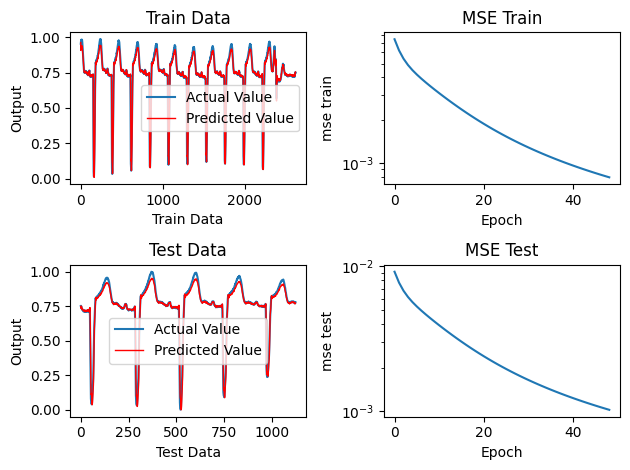

In [5]:

for t in range(epochs):

    # train dataset feed forward and Back Propagation

    h_state1, c_state1 = np.zeros(hidden_size), np.zeros((hidden_size, 1))  # Reset states at the start of train dataset
    h_state2, c_state2 = np.zeros(hidden_size), np.zeros((hidden_size, 1))  # Reset states at the start of train dataset

    for i in range(num_train):
        lstm_r_out = []
        lstm_l_out = []
        x_seq = X_train[i]
        # feed forward
        index = 0
        for x in x_seq:
            y_pred1, h_state1, c_state1 = lstm_list_r[index].forward(x, h_state1, c_state1)
            lstm_r_out.append(y_pred1)
            index += 1

        index = 0
        for x in reversed(x_seq):
            y_pred2, h_state2, c_state2 = lstm_list_l[index].forward(x, h_state2, c_state2)
            lstm_l_out.append(y_pred2)
            index += 1

        y_pred = np.concatenate((lstm_r_out[0][:,0], lstm_l_out[0][:,0]), axis=0)
        for j in range(1,len(lstm_l_out)):
          y_pred = np.concatenate((y_pred, lstm_r_out[j][:,0]), axis=0)
          y_pred = np.concatenate((y_pred, lstm_l_out[j][:,0]), axis=0)

        net_y = Wy.dot(y_pred).reshape(-1,1)
        o_y = choose_function(net_y,"pureline")[0][0]

        dL_dh = eta*(Y_train[i]- o_y) * -1 * choose_function_derivate(net_y,"pureline").dot(Wy).T
        dh_state_next1 = np.zeros_like(h_state1)
        dc_state_next1 = np.zeros_like(c_state1)
        dh_state_next2 = np.zeros_like(h_state2)
        dc_state_next2 = np.zeros_like(c_state2)

        # Back Propagation
        index = 0
        index1 = 0
        for x in reversed(x_seq):
            dh_state_next1, dc_state_next1 = lstm_list_r[index].backward(dL_dh[index1*hidden_size:(index1+1)*hidden_size], dh_state_next1, dc_state_next1, eta , index)
            index +=1
            index1 +=2

        index = 0
        index1 = 1
        for x in x_seq:
            dh_state_next2, dc_state_next2 = lstm_list_l[index].backward(dL_dh[index1*hidden_size:(index1+1)*hidden_size], dh_state_next2, dc_state_next2, eta , index)
            index+=1
            index1+=2

        Wy -= eta * (Y_train[i] - o_y) * -1 * np.diagflat(choose_function_derivate(net_y,"pureline")).dot(y_pred.reshape(-1,1).T)


    # train dataset display MSE and output

    h_state1, c_state1 = np.zeros(hidden_size), np.zeros((hidden_size, 1))  # Reset states at the start of train dataset
    h_state2, c_state2 = np.zeros(hidden_size), np.zeros((hidden_size, 1))  # Reset states at the start of train dataset

    for i in range(num_train):
        lstm_r_out = []
        lstm_l_out = []
        x_seq = X_train[i]

        # feed forward
        index = 0
        for x in x_seq:
            y_pred1, h_state1, c_state1 = lstm_list_r[index].forward(x, h_state1, c_state1)
            lstm_r_out.append(y_pred1)
            index += 1

        index = 0
        for x in reversed(x_seq):
            y_pred2, h_state2, c_state2 = lstm_list_l[index].forward(x, h_state2, c_state2)
            lstm_l_out.append(y_pred2)
            index += 1

        y_pred = np.concatenate((lstm_r_out[0][:,0], lstm_l_out[0][:,0]), axis=0)
        for j in range(1,len(lstm_l_out)):
          y_pred = np.concatenate((y_pred, lstm_r_out[j][:,0]), axis=0)
          y_pred = np.concatenate((y_pred, lstm_l_out[j][:,0]), axis=0)

        net_y = Wy.dot(y_pred).reshape(-1,1)
        o_y = choose_function(net_y,"pureline")[0][0]

        mse_error_train[i] = Y_train[i] - o_y
        output_data_train[i] = o_y




    h_state1, c_state1 = np.zeros(hidden_size), np.zeros((hidden_size, 1))  # Reset states at the start of train dataset
    h_state2, c_state2 = np.zeros(hidden_size), np.zeros((hidden_size, 1))  # Reset states at the start of train dataset
    # test dataset display MSE and output
    for i in range(num_test):
        lstm_r_out = []
        lstm_l_out = []
        x_seq = X_test[i]


        # feed forward
        index = 0
        for x in x_seq:
            y_pred1, h_state1, c_state1 = lstm_list_r[index].forward(x, h_state1, c_state1)
            lstm_r_out.append(y_pred1)
            index += 1

        index = 0
        for x in reversed(x_seq):
            y_pred2, h_state2, c_state2 = lstm_list_l[index].forward(x, h_state2, c_state2)
            lstm_l_out.append(y_pred2)
            index += 1

        y_pred = np.concatenate((lstm_r_out[0][:,0], lstm_l_out[0][:,0]), axis=0)
        for j in range(1,len(lstm_l_out)):
          y_pred = np.concatenate((y_pred, lstm_r_out[j][:,0]), axis=0)
          y_pred = np.concatenate((y_pred, lstm_l_out[j][:,0]), axis=0)

        net_y = Wy.dot(y_pred).reshape(-1,1)
        o_y = choose_function(net_y,"pureline")[0][0]

        mse_error_test[i] = Y_test[i] - o_y
        output_data_test[i] = o_y



    mse_train[t] = np.mean(mse_error_train**2)
    mse_test[t] = np.mean(mse_error_test**2)

    fig=plt.figure(2)
    plt.subplot(2, 2, 1)
    plt.cla()  # Clear the previous plot
    plt.plot(Y_train, label="Actual Value")
    plt.plot(output_data_train, 'r', linewidth=1, label="Predicted Value")
    plt.legend()
    plt.title('Train Data')
    plt.xlabel('Train Data')
    plt.ylabel('Output')

    # The MSE train data plot
    plt.subplot(2, 2, 2)
    plt.cla()
    plt.semilogy(mse_train[:t])
    plt.title('MSE Train')
    plt.xlabel('Epoch')
    plt.ylabel('mse train')
    fig.tight_layout()

    plt.subplot(2, 2, 3)
    plt.cla()
    plt.plot(Y_test, label="Actual Value")
    plt.plot(output_data_test, 'r', linewidth=1, label="Predicted Value")
    plt.legend()
    plt.title('Test Data')
    plt.xlabel('Test Data')
    plt.ylabel('Output')

    # MSE test data plot
    plt.subplot(2, 2, 4)
    plt.cla()
    plt.semilogy(mse_test[:t])
    plt.title('MSE Test')
    plt.xlabel('Epoch')
    plt.ylabel('mse test')
    fig.tight_layout()
    display(plt.gcf())

    clear_output(wait=True)

## **Regression Plot**

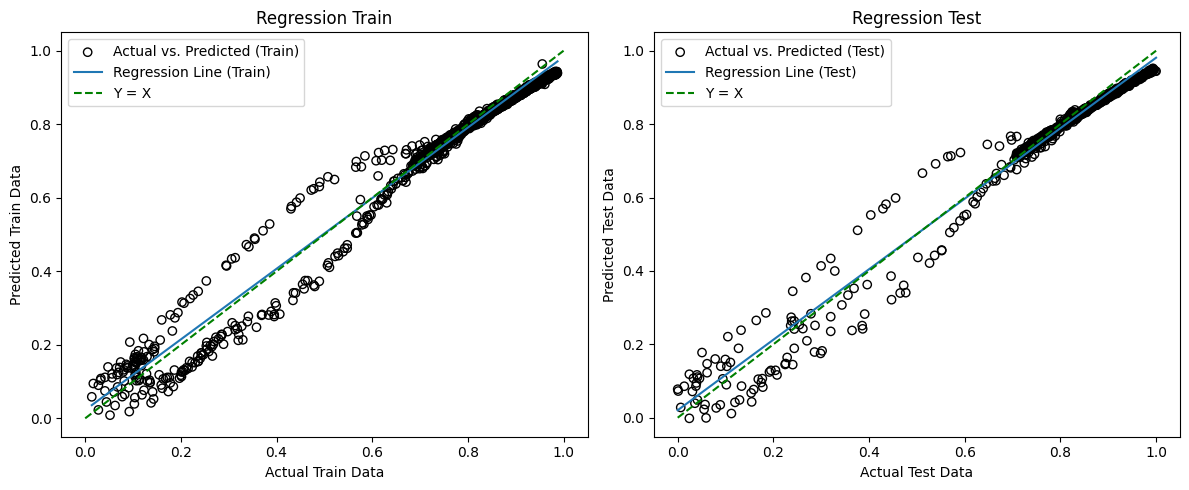

In [6]:
import matplotlib.pyplot as plt
numb_shift = number_feature
# Regression Train Plot
plt.figure(5, figsize=(12, 5))
numb_shift-=1

plt.subplot(1, 2, 1)
plt.scatter(data[:num_train, numb_shift], output_data_train, label='Actual vs. Predicted (Train)', marker='o', edgecolors='black', facecolors='none')
plot_regression_line(data[:num_train, numb_shift], output_data_train, 'Regression Line (Train)')
plt.plot([min(data[:, numb_shift]), max(data[:, numb_shift])], [min(data[:, numb_shift]), max(data[:, numb_shift])], label='Y = X', color='green', linestyle='--')

plt.xlabel('Actual Train Data')
plt.ylabel('Predicted Train Data')
plt.title('Regression Train')
plt.legend()

# Regression Test Plot
plt.subplot(1, 2, 2)
plt.scatter(data[num_train:num_train + num_test, numb_shift], output_data_test[:num_test], label='Actual vs. Predicted (Test)', marker='o', edgecolors='black', facecolors='none')
plot_regression_line(data[num_train:num_train + num_test, numb_shift], output_data_test[:num_test], 'Regression Line (Test)')
plt.plot([min(data[:, numb_shift]), max(data[:, numb_shift])], [min(data[:, numb_shift]), max(data[:, numb_shift])], label='Y = X', color='green', linestyle='--')

plt.xlabel('Actual Test Data')
plt.ylabel('Predicted Test Data')
plt.title('Regression Test')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
print("The MSE of Train is : ")
for i in range(len(mse_train)):
  print(f"Epoch {i+1} : {mse_train[i]}")

print("\n\nThe MSE of test is : ")
for i in range(len(mse_test)):
  print(f"Epoch {i+1} : {mse_test[i]}")


The MSE of Train is : 
Epoch 1 : 0.007428802292709863
Epoch 2 : 0.006200181493562294
Epoch 3 : 0.0054220098562262785
Epoch 4 : 0.004892066257579728
Epoch 5 : 0.004499155223522335
Epoch 6 : 0.004184337628221268
Epoch 7 : 0.00391694747475697
Epoch 8 : 0.003681007212629154
Epoch 9 : 0.0034680015296793
Epoch 10 : 0.0032731795719714843
Epoch 11 : 0.003093700104110597
Epoch 12 : 0.00292770659420524
Epoch 13 : 0.002773863996298671
Epoch 14 : 0.0026311241214029726
Epoch 15 : 0.0024986050277529645
Epoch 16 : 0.0023755281515335878
Epoch 17 : 0.0022611852607947822
Epoch 18 : 0.002154921114003911
Epoch 19 : 0.00205612448335289
Epoch 20 : 0.001964223602197759
Epoch 21 : 0.0018786838579812914
Epoch 22 : 0.0017990065068426131
Epoch 23 : 0.0017247277294280894
Epoch 24 : 0.0016554176692977658
Epoch 25 : 0.0015906792895996902
Epoch 26 : 0.0015301469993964027
Epoch 27 : 0.0014734850661895053
Epoch 28 : 0.0014203858634780418
Epoch 29 : 0.0013705680136180565
Epoch 30 : 0.0013237744852328788
Epoch 31 : 0.00